In [358]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [359]:
features_path = 'selected_features.csv'
df = pd.read_csv(features_path)
df = df[~df.isin([float('inf'), float('-inf')]).any(axis=1)]
df.reset_index(drop=True, inplace=True)

print(df.head()) 


   fixation_duration_mean  saccade_duration_mean  yawv_min_head  \
0                1.076052               0.023799       0.022109   
1                0.359459               0.021473       0.008119   
2                0.251128               0.022591       0.008838   
3                0.197616               0.020964       0.013447   
4                0.237235               0.019765       0.009362   

   pitchv_min_head  yaw_max_rwrist  pitch_mean_rwrist  pitch_max_rwrist  \
0         0.021982        0.522503          -0.305785          0.611486   
1         0.022433        0.428694          -0.056648          0.722147   
2         0.005225        0.526114           0.359154          0.815364   
3         0.006873        0.530373           0.258947          0.692431   
4         0.038537        0.411989          -0.309174          0.699319   

   pitch_min_rwrist  linv_min_rwrist  x_max_acc  x_max_gyro  y_mean_gyro  \
0         -0.611036         0.037374  10.969936    0.772303     0.0180

In [360]:
df = df.fillna(0)
rows_before = df.shape[0]
rows_after = df.shape[0]

print(f"Rows before: {rows_before}, Rows after: {rows_after}")

Rows before: 195, Rows after: 195


In [361]:
X = df.drop(columns=['label'])
y = df['label']

In [362]:
#train train spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [363]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [364]:
class MLP4(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP4, self).__init__()

        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.out = nn.Linear(4, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [365]:
class MLP6(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP6, self).__init__()

        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        self.out = nn.Linear(4, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [366]:
class MLP8(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP8, self).__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 4)
        self.fc7 = nn.Linear(4, 2)
        self.out = nn.Linear(2, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x


In [367]:
num_epochs=1000
lr=0.0005
dropout=0.1
batch_size=64

In [368]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr.to_numpy(), dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte.to_numpy(), dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [369]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP4(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch [1/1000], Loss: 0.6950
Epoch [2/1000], Loss: 0.6907
Epoch [3/1000], Loss: 0.6942
Epoch [4/1000], Loss: 0.6860
Epoch [5/1000], Loss: 0.6839
Epoch [6/1000], Loss: 0.6868
Epoch [7/1000], Loss: 0.6909
Epoch [8/1000], Loss: 0.6899
Epoch [9/1000], Loss: 0.6870
Epoch [10/1000], Loss: 0.6905
Epoch [11/1000], Loss: 0.6911
Epoch [12/1000], Loss: 0.6842
Epoch [13/1000], Loss: 0.6840
Epoch [14/1000], Loss: 0.6914
Epoch [15/1000], Loss: 0.6852
Epoch [16/1000], Loss: 0.6861
Epoch [17/1000], Loss: 0.6836
Epoch [18/1000], Loss: 0.6835
Epoch [19/1000], Loss: 0.6869
Epoch [20/1000], Loss: 0.6842
Epoch [21/1000], Loss: 0.6881
Epoch [22/1000], Loss: 0.6876
Epoch [23/1000], Loss: 0.6857
Epoch [24/1000], Loss: 0.6839
Epoch [25/1000], Loss: 0.6819
Epoch [26/1000], Loss: 0.6858
Epoch [27/1000], Loss: 0.6844
Epoch [28/1000], Loss: 0.6839
Epoch [29/1000], Loss: 0.6848
Epoch [30/1000], Loss: 0.6859
Epoch [31/1000], Loss: 0.6899
Epoch [32/1000], Loss: 0.6843
Epoch [33/1000], Loss: 0.6862
Epoch [34/1000], Lo

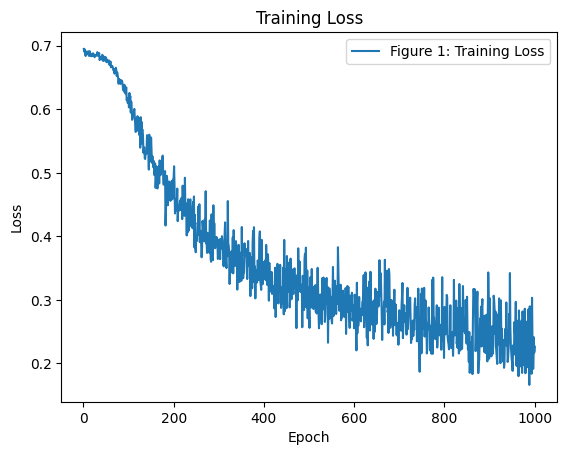

In [370]:
# Training loop
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
plt.plot(range(1, num_epochs + 1), losses, label='Figure 1: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.pause(0.01)

### Model Performance

In [371]:
y_pred=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

ACC:0.5128205128205128


In [372]:
y_pred=model(Xtr)
print(f'ACC:{accuracy_score(ytr.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

ACC:0.8653846153846154


In [378]:
# Evaluate the best model on the test set (Xte, yte)
y_pred = model(Xte).detach().numpy() > 0.5
test_accuracy = accuracy_score(yte.detach().numpy(), y_pred)
test_f1 = f1_score(yte.detach().numpy(), y_pred)
test_precision = precision_score(yte.detach().numpy(), y_pred)
test_recall = recall_score(yte.detach().numpy(), y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.5897
Test F1 Score: 0.5000
Test Precision: 0.8889
Test Recall: 0.3478


In [379]:
# Evaluate the best model on the test set (Xte, yte)
y_pred2 = model(Xtr).detach().numpy() > 0.5
train_accuracy = accuracy_score(ytr.detach().numpy(), y_pred2)
train_f1 = f1_score(ytr.detach().numpy(), y_pred2)
train_precision = precision_score(ytr.detach().numpy(), y_pred2)
train_recall = recall_score(ytr.detach().numpy(), y_pred2)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")

Train Accuracy: 0.9038
Train F1 Score: 0.8905
Train Precision: 0.9385
Train Recall: 0.8472


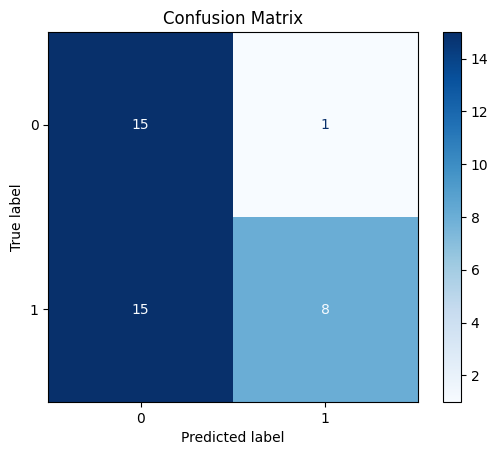

In [380]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(yte.detach().numpy(), y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

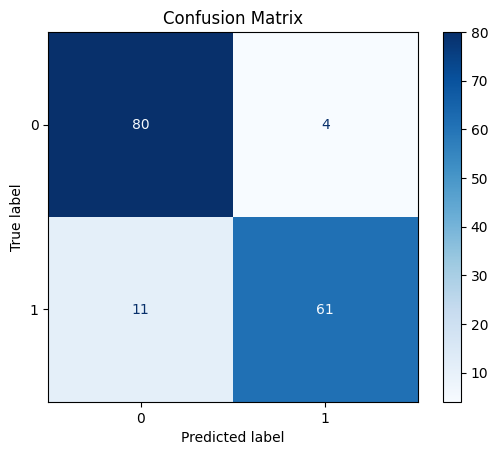

In [381]:
# Generate confusion matrix
cm = confusion_matrix(ytr.detach().numpy(), y_pred2)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_train.png")
plt.show()